# DCGAN
Bir önceki yazıda bahsettiğim Vanilla GAN modelinden daha iyi sonuçlar veren DCGAN modelini inceleyelim. Makalede de bahsedildiği gibi MaxPooling ve Dense layerlar yerine stride ve transposed convolution kullarak downsampling ve upsampling işlemleri uygulanır. Bunlara yazının ilerleyen kısımlarında değineceğiz.  
Generator random olarak alınan noise verisini kullanarak bir resim üretir. Bu resmi girdi olarak alan discriminator modeli basit bir sınıflandırma modeli ile gerçek yada sahte olarak sınıflandırır. Generatorün amacı discriminator modelini kandırmaktır. 

### DCGAN Genel Özeti
* Max Pooling katmanlarını Convolutional Stride ile değiştir.
* Upsampling için transposed convolution kullan.
* Dense layer kullanma. 
* Generator ve Discriminator modellerin outputları dışında Batch Normalization kullan.
* Generatorde relu kullan, Discriminatorde LeakyReLU kullan.

In [1]:
import os 
import glob
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt 

import tensorflow as tf

from tensorflow.keras.layers import (Dense,
                                     Reshape,
                                     Conv2DTranspose
                                     ,Conv2D,
                                     BatchNormalization,
                                     LeakyReLU,
                                     Input,
                                     Dropout,
                                     Flatten)

from tensorflow.keras.models import Model
from tqdm import tqdm
import pickle


In [2]:
tf.__version__

'2.4.1'

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Kullanılacak Veri Seti
Biz DCGAN kullanarak random noise verisinden insan yüzleri oluşturmaya çalışcağız. Bunu yapabilmek için CelebFaces Attributes (CelebA) veri sertini kullanacağız. CelebA verisetinde 200 binden fazla insan yüzü bulunuyor. Bu yüzleri kullanarak generator modeli eğitip benzer insan yüzleri oluşturmasını bekliyoruz.

In [4]:
DATA_PATH = "C:\\Users\\bagat\\Desktop\\datasets\\faceceleb\\img_align_celeba\\img_align_celeba\\*jpg"
H,W,C = 64,64,3
CROP_FACE = (30,55,150,175) #left top right bottom
LATENT_DIM = 100
INPUT_SHAPE = (H,W,C)
EPOCHS = 30000
BATCH_SIZE = 64
SAMPLE_PERIOD = 200

In [5]:
all_images_path = glob.glob(DATA_PATH)
print("Total image use for DCGAN : ",len(all_images_path))



Total image use for DCGAN :  202599


Burada resimleri PIL kütüphanesi kullanarak okuyoruz. Crop metodu ile resimlerden yüz kısımlarını kesiyoruz ve resize ile modele göndereceğimiz 64x64 şekline getiriyoruz. Aynı zamanda okuduğumuz resimleri -1 ile 1 arasına normalize ediyoruz. 

In [6]:
x_train = [(np.array(Image.open(i).crop(CROP_FACE).resize((H,W)))-127.5)/127.5 for i in tqdm(all_images_path)]

100%|█████████████████████████████████████████████████████████████████████████| 202599/202599 [04:29<00:00, 750.56it/s]


In [7]:
x_train = np.array(x_train)
x_train.shape

(202599, 64, 64, 3)

In [8]:
x_train[0][:2,:2,0] # 0-1 normalizde

array([[0.99215686, 0.99215686],
       [0.99215686, 0.99215686]])

In [9]:
# with open("pickles/x_train.pickle","wb") as file:
#     pickle.dump(x_train,file)

Veri setinde bulunan resimlerden random olarak 16 tane seçip bunları plot ediyoruz

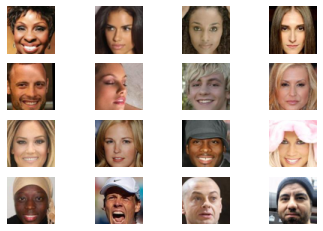

In [48]:
rows = 4 
cols = 4
fig,axs = plt.subplots(rows,cols)
for i in range(rows):
    for j in range(cols):
        idx = np.random.randint(0,x_train.shape[0])
        axs[i,j].imshow(x_train[idx]*0.5+0.5)
        axs[i,j].axis("off")

## Transpose Convolution 
Transposed Convolution girdinin, öğrenebilen filtreler kullanarak upsample işlemi yapılmasıdır.  
Aşağıdaki örnekte yapılan işlemi takip ederek daha iyi anlayabilirsiniz. 

# Modeller 
# Generator 
Generator input olarak belirtilen latent dim boyutunda bu örnekte 100 random sayı alır. Bu random sayıları bir Dense layera göndeririz. Daha sonra Conv2DTranspose ile tranpose conv işlemine sokarız. Alınan inputun Height ve Width değerleri her adımda 2 kat olacak şekilde büyütülür. Bunu stride değeri ile sağlarız. En son katmanda 64x64x3 boyutlarında bir resim çıktısı bekleriz. Çıktı katmanınında resmi -1 ile 1 arasına scale ettiğimiz için aktivasyon fonksiyonu olarak tanh kullanırız.  

In [49]:
def build_generator(latent_dim):
    inputx = Input(shape=(latent_dim,))
    x = Dense(4*4*512)(inputx)
    x = LeakyReLU(alpha=.2)(x)
    x = Reshape([4,4,512])(x)
    x = Conv2DTranspose(256,4,strides=2,padding="same")(x) #16x16
#     x = BatchNormalization()(x)
    x = LeakyReLU(alpha=.2)(x)
    x = Conv2DTranspose(128,4,strides=2,padding="same")(x) # 32x32
    x = LeakyReLU(alpha=.2)(x)
#     x = BatchNormalization()(x)
    x = Conv2DTranspose(64,4,strides=2,padding="same")(x) # 64x64
    x = LeakyReLU(alpha=.2)(x)
#     x = BatchNormalization()(x)

 
    x = Conv2DTranspose(3,5,strides=2,padding="same",activation="tanh")(x)

    model = Model(inputx,x)
    return model

    
    

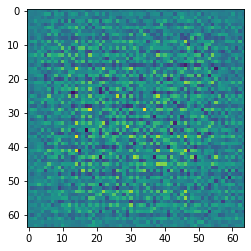

In [50]:
generator_model = build_generator(LATENT_DIM)
noise = np.random.randn(1,LATENT_DIM)
fake_img = generator_model.predict(noise)
plt.imshow(fake_img[0,:,:,0])

In [51]:
generator_model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense_15 (Dense)             (None, 8192)              827392    
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_26 (Conv2DT (None, 8, 8, 256)         2097408   
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_27 (Conv2DT (None, 16, 16, 128)       524

### Discriminator Modeli 
Generator modelden gelen 64x64x3 boyutlarında resmi bir CNN modeline sokarız. Burada amacımız sınıflandırma yapmaktı. Çıktı olarak resmin gerçek mi sahtemi olduğunu döndürürüz. Bunun için 0 ile 1 arasında değer sigmoid aktivasyon fonksiyonu kullanırız. 

In [52]:
def build_discriminator(input_shape):
    inputx = Input(shape=input_shape)
    x = Conv2D(64,3,padding="same")(inputx)
    x = LeakyReLU(alpha=.2)(x)
    x = Dropout(.3)(x)
    x = Conv2D(64,3,strides=(2,2),padding="same")(x)
    x = LeakyReLU(alpha=.2)(x)
    x = Dropout(.3)(x)
    x = Conv2D(128,3,strides=(2,2),padding="same")(x)
    x = LeakyReLU(alpha=.2)(x)
    x = Dropout(.3)(x)
    x = Conv2D(128,3,strides=(2,2),padding="same")(x)
    x = LeakyReLU(alpha=.2)(x)
    x = Flatten()(x)
    x = Dense(1,activation="sigmoid")(x)
    
    model = Model(inputx,x)
    return model

In [53]:
disc_model = build_discriminator(INPUT_SHAPE)
disc_model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
leaky_re_lu_64 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_65 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 32, 32, 64)        0  

## Combined Model
Generator ve Discriminayor modeli birleştirerek Combined model oluştururuz. Combined modelde generator input olarak noise alır ve bir resim üretir. Üretilen resim discriminator modele gönderilir. Discriminator model alınan resim sonucunda gerçek yada sahte çıktısını verir. 

In [54]:
generator_model = build_generator(LATENT_DIM)
disc_model = build_discriminator(INPUT_SHAPE)
disc_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5),loss="binary_crossentropy",metrics=["accuracy"])

input = Input(shape=(LATENT_DIM,))
img = generator_model(input)
disc_model.trainable=False
pred = disc_model(img)

combined_model = Model(input,pred)
combined_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5),loss="binary_crossentropy")

combined_model.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
model_19 (Functional)        (None, 64, 64, 3)         3585155   
_________________________________________________________________
model_20 (Functional)        (None, 1)                 268353    
Total params: 3,853,508
Trainable params: 3,585,155
Non-trainable params: 268,353
_________________________________________________________________


In [55]:
d_losses = list()
g_losses = list()

ones = np.ones(BATCH_SIZE)
zeros = np.zeros(BATCH_SIZE)

In [56]:
def save_sample(epoch):
    rows,cols = 4,4
    noise = np.random.randn(rows*cols,LATENT_DIM)
    imgs = generator_model.predict(noise)

    fig,axs = plt.subplots(rows,cols)
    ids = 0 
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[ids].reshape(H,W,3)*.5+0.5)
            axs[i,j].axis("off")
            ids +=1

    fig.savefig(f"C:\\Users\\bagat\\Desktop\\Projects\\GAN\\generated\\{epoch}.png")
    plt.close()

## Model Eğitimi 
Generator bir image üretir. Bunu sahte olarak etiketleyip discriminator modele göndeririz. Aynı zamanda discriminator modele gerçek resimde gönderilir. Bunu da gerçek etiketi ile etiketleriz. Bu şekilde discriminator modelin sahte ve gerçek resim arasında ayrım yapmaya yönelik eğitmeye başlarız.
Bu adımdan sonra sıra combined modeldedir. Generator modele noise gönderilir. Generator bir resim üretir. Bunu gerçek olarak etiketleyip discriminator modele göndeririz. Discriminator model gönderilen resmin gerçek mi sahte mi olduğu konusunda çıktı üretir. Ancak biz gönderdiğimiz resmi gerçek olarak etiketlemiştik. Bu resmin gerçeğe yakınsaması için backpropagation ile generator model eğitilir. Bir sonraki adımda daha gerçek resimler üretilir.

In [57]:

for epoch in range(EPOCHS):
    ids = np.random.randint(0,x_train.shape[0],BATCH_SIZE)
    real_imgs = x_train[ids]

    noise = np.random.randn(BATCH_SIZE,LATENT_DIM)
    fake_imgs = generator_model(noise)

    d_loss_real , d_acc_real = disc_model.train_on_batch(real_imgs,ones)
    d_loss_fake , d_acc_fake = disc_model.train_on_batch(fake_imgs,zeros)

    
    d_loss = (d_loss_real+d_loss_fake)/2
    d_acc = (d_acc_real+d_acc_fake)/2

    noise = np.random.randn(BATCH_SIZE,LATENT_DIM)
    g_loss = combined_model.train_on_batch(noise,ones)

    noise = np.random.randn(BATCH_SIZE,LATENT_DIM)
    g_loss = combined_model.train_on_batch(noise,ones)

    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if epoch%100 == 0 :
        print(f"Epoch : {epoch} d_loss : {d_loss:.2f} d_acc : {d_acc:.2f} g_loss: {g_loss:.2f}")

    if epoch%SAMPLE_PERIOD==0:
        save_sample(epoch)

Epoch : 0 d_loss : 0.68 d_acc : 0.45 g_loss: 0.69
Epoch : 100 d_loss : 0.66 d_acc : 0.68 g_loss: 1.03
Epoch : 200 d_loss : 0.68 d_acc : 0.59 g_loss: 0.77
Epoch : 300 d_loss : 0.73 d_acc : 0.20 g_loss: 0.69
Epoch : 400 d_loss : 0.70 d_acc : 0.32 g_loss: 0.58
Epoch : 500 d_loss : 0.67 d_acc : 0.70 g_loss: 0.78
Epoch : 600 d_loss : 0.72 d_acc : 0.56 g_loss: 0.90
Epoch : 700 d_loss : 0.66 d_acc : 0.68 g_loss: 0.81
Epoch : 800 d_loss : 0.59 d_acc : 0.80 g_loss: 0.69
Epoch : 900 d_loss : 0.70 d_acc : 0.38 g_loss: 0.65
Epoch : 1000 d_loss : 0.68 d_acc : 0.68 g_loss: 0.80
Epoch : 1100 d_loss : 0.59 d_acc : 0.69 g_loss: 0.99
Epoch : 1200 d_loss : 0.65 d_acc : 0.63 g_loss: 1.00
Epoch : 1300 d_loss : 0.68 d_acc : 0.59 g_loss: 0.88
Epoch : 1400 d_loss : 0.62 d_acc : 0.78 g_loss: 0.82
Epoch : 1500 d_loss : 0.62 d_acc : 0.74 g_loss: 0.87
Epoch : 1600 d_loss : 0.58 d_acc : 0.67 g_loss: 0.99
Epoch : 1700 d_loss : 0.60 d_acc : 0.62 g_loss: 1.15
Epoch : 1800 d_loss : 0.51 d_acc : 0.91 g_loss: 0.85
Epoch